In [ ]:
pip install kagglehub

In [ ]:
!kaggle datasets download -d rm1000/brain-tumor-mri-scans


Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 99% 234M/236M [00:11<00:00, 26.1MB/s]
100% 236M/236M [00:11<00:00, 20.9MB/s]


In [ ]:
!unzip /content/brain-tumor-mri-scans.zip -d /content/brain-tumor-mri-scans/


Streaming output truncated to the last 5000 lines.
  inflating: /content/brain-tumor-mri-scans/healthy/0402.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0403.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0404.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0405.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0406.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0407.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0408.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0409.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0410.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0411.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0412.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0413.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0414.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0415.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0416.jpg  
  in

In [3]:
import os
dataset_path = '/content/brain-tumor-mri-scans/'

# List the folders inside the dataset directory
print(os.listdir(dataset_path))


['healthy', 'glioma', 'meningioma', 'pituitary']


In [4]:
from PIL import Image

image_dir = "/content/brain-tumor-mri-scans/"  # Change to the actual path

# Categories
categories = ["glioma", "healthy", "meningioma", "pituitary"]

# Function to check image integrity
def check_image_integrity(image_dir):
    corrupted_files = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # Verify if the image is readable
        except (IOError, SyntaxError) as e:
            corrupted_files.append(img_file)
    return corrupted_files

# Iterate through each category and check for corrupted images
for category in categories:
    category_path = os.path.join(image_dir, category)
    corrupted = check_image_integrity(category_path)
    if corrupted:
        print(f"Corrupted images in {category}: {corrupted}")
        # Remove corrupted files
        for corrupted_img in corrupted:
            os.remove(os.path.join(category_path, corrupted_img))
    else:
        print(f"No corrupted images in {category}")


No corrupted images in glioma
No corrupted images in healthy
No corrupted images in meningioma
No corrupted images in pituitary


In [5]:
import os
import cv2 as cv
import numpy as np

In [6]:
dir = 'brain-tumor-mri-scans'

images=[]
labels=[]
label_map = {'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}

for folder in os.listdir(dir):
    fol_path=os.path.join(dir,folder)
    print(folder)
    print(fol_path)
    for image in os.listdir(fol_path):
        img=cv.imread(os.path.join(fol_path,image)).astype('float32')
        img=cv.resize(img,(128,128))
        images.append(img)
        labels.append(folder)

healthy
brain-tumor-mri-scans/healthy
glioma
brain-tumor-mri-scans/glioma
meningioma
brain-tumor-mri-scans/meningioma
pituitary
brain-tumor-mri-scans/pituitary


In [7]:
#Conversion to Numpy Arrays

images = np.array(images)
labels = np.array(labels)

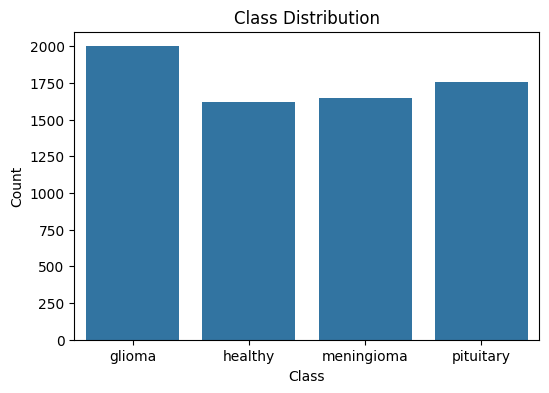

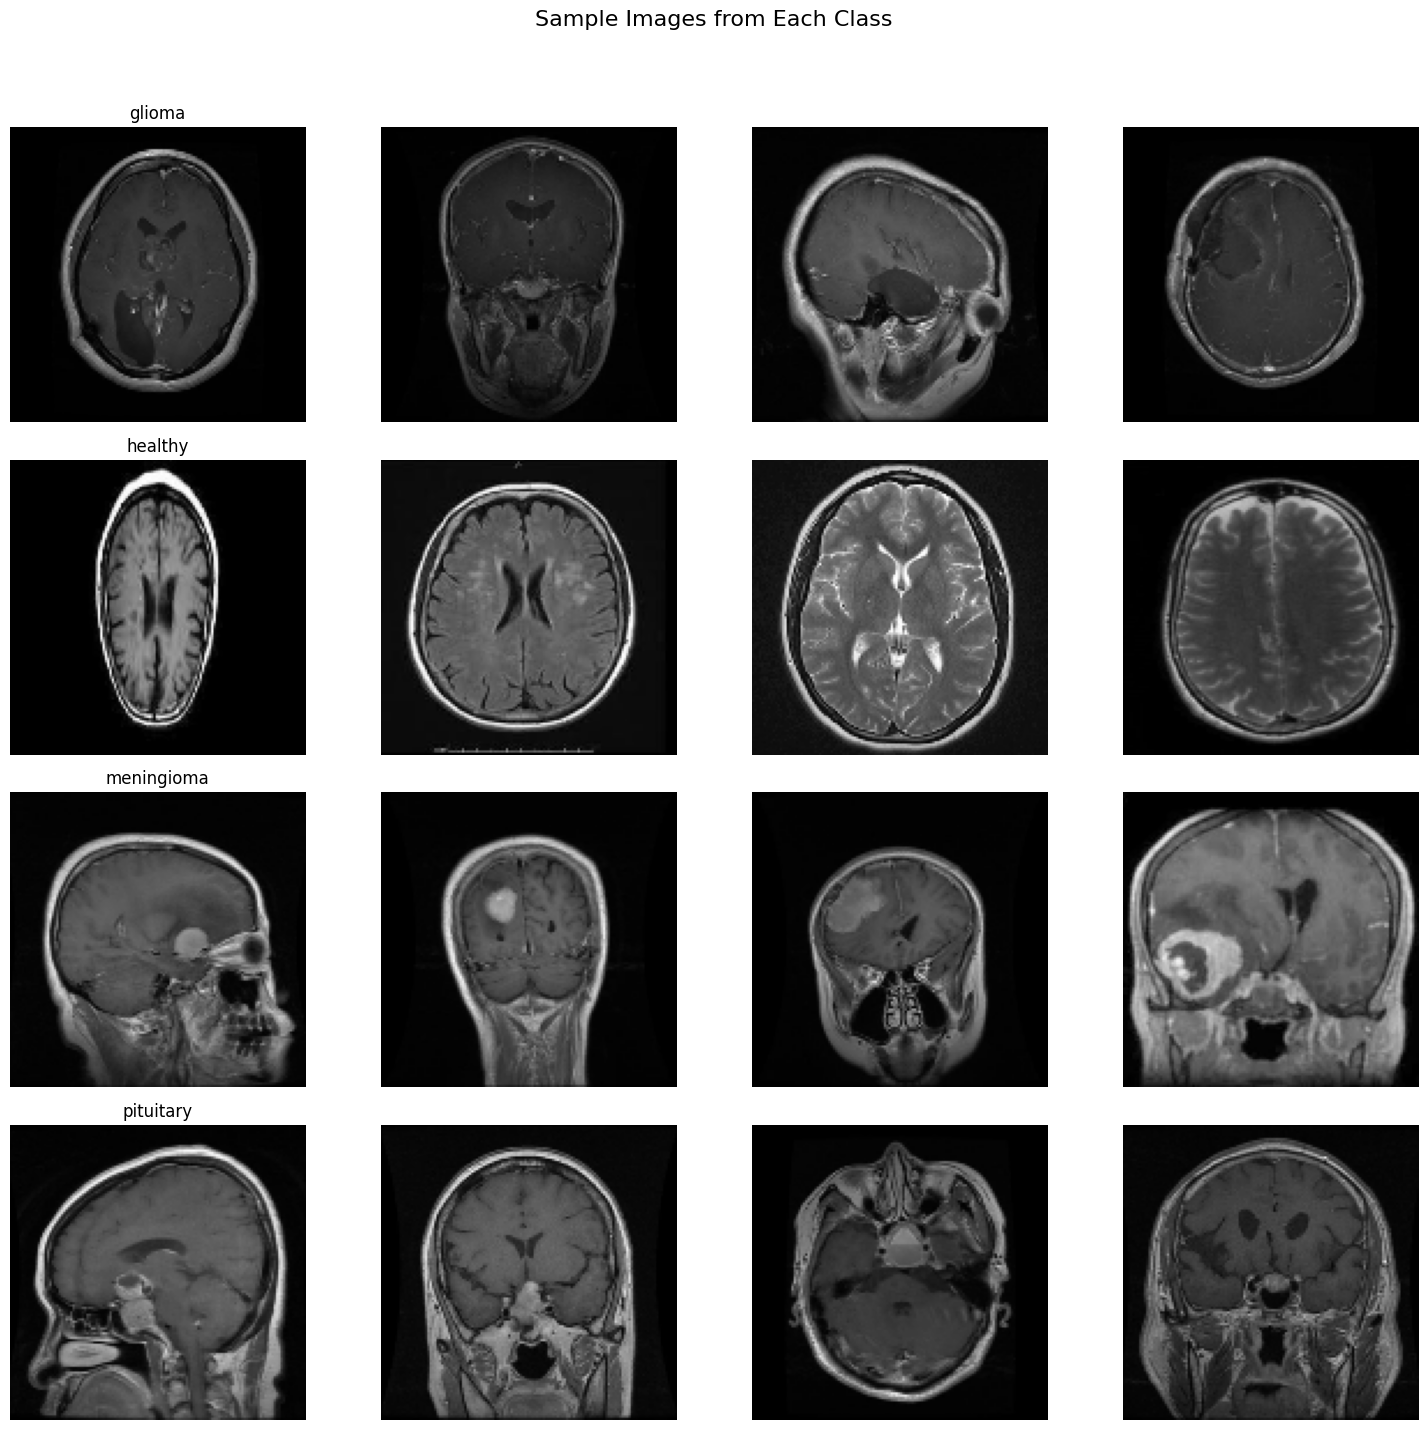

In [8]:
#Exploratory Data Visualization (EDA)

import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters
IMG_SIZE = (128, 128)
batch_size = 32
EPOCHS = 10

plt.figure(figsize=(6, 4))
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(4), labels=label_map.keys())
plt.show()

# Display 4 images from each class
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for row, (label_name, label) in enumerate(label_map.items()):
    sample_img_paths = glob.glob(os.path.join(dir, label_name, '*.jpg'))[:4]
    for col, img_path in enumerate(sample_img_paths):
        sample_img = cv.imread(img_path)
        sample_img = cv.cvtColor(sample_img, cv.COLOR_BGR2RGB)  # Convert color for accurate display
        axs[row, col].imshow(cv.resize(sample_img, IMG_SIZE))
        axs[row, col].set_title(label_name if col == 0 else "")
        axs[row, col].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
#Importing Libraries for ML Model and Classification

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve, auc

In [10]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [11]:
# Normalize and preprocess data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [12]:
# Load ResNet50 with ImageNet weights and remove the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Extract features from the images using ResNet50
X_train_features = base_model.predict(X_train)
X_test_features = base_model.predict(X_test)

# Flatten the extracted features for PCA
X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

# Apply PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_features_flat)
X_test_pca = pca.transform(X_test_features_flat)

176/176 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step


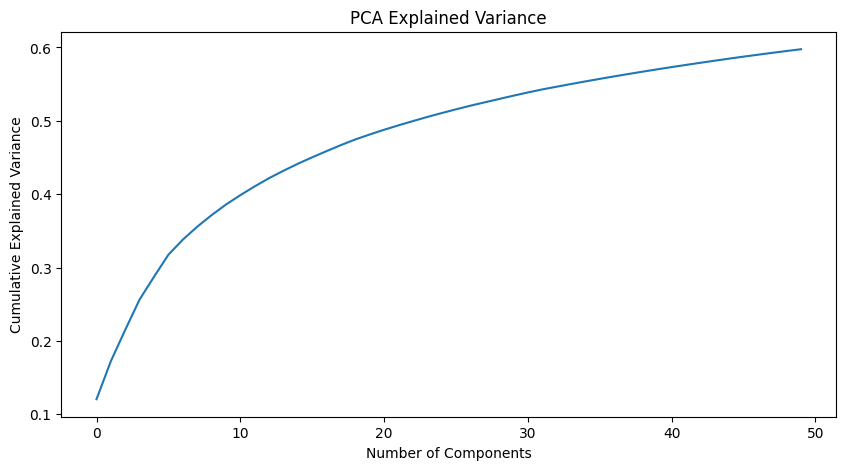

In [13]:
# Visualize explained variance to determine effectiveness of PCA
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the labels and transform them into numerical representations
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode labels
y_train_cat = to_categorical(y_train_encoded, num_classes=4)
y_test_cat = to_categorical(y_test_encoded, num_classes=4)

In [15]:
# Define the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import time

# Define image data generator for data augmentation
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply the data generator to the training data
train_generator = data_gen.flow(X_train, y_train_cat, batch_size=32)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Measure total training time
start_time = time.time()

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=(X_test, y_test_cat),
    steps_per_epoch=len(X_train) // 32,
    callbacks=[early_stopping, reduce_lr]
)

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f} seconds")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and metrics
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test_cat.argmax(axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))



Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.7876 - loss: 0.5515 - val_accuracy: 0.6470 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 2/15
  1/175 ━━━━━━━━━━━━━━━━━━━━ 8:08 3s/step - accuracy: 0.6875 - loss: 0.7623

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


175/175 ━━━━━━━━━━━━━━━━━━━━ 145s 817ms/step - accuracy: 0.6875 - loss: 0.7623 - val_accuracy: 0.6512 - val_loss: 1.0061 - learning_rate: 0.0010
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 539s 3s/step - accuracy: 0.8134 - loss: 0.4900 - val_accuracy: 0.6242 - val_loss: 1.1330 - learning_rate: 0.0010
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 144s 816ms/step - accuracy: 0.7188 - loss: 0.7422 - val_accuracy: 0.6335 - val_loss: 1.1075 - learning_rate: 0.0010
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 573s 3s/step - accuracy: 0.8234 - loss: 0.4765 - val_accuracy: 0.6562 - val_loss: 0.9310 - learning_rate: 0.0010
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 88s 494ms/step - accuracy: 0.7500 - loss: 0.6162 - val_accuracy: 0.6520 - val_loss: 0.9254 - learning_rate: 0.0010
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.8317 - loss: 0.4373 - val_accuracy: 0.6456 - val_loss: 1.1383 - learning_rate: 0.0010
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 144s 816ms/step - accuracy: 0.7500 - loss: 0.

In [21]:
# Cross-Validation with StratifiedKFold
skf = StratifiedKFold(n_splits=5)
f1_scores = []
roc_aucs = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train_cat[train_index], y_train_cat[val_index]

    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold),
                        epochs=EPOCHS, batch_size=batch_size, verbose=0)

    y_val_pred = model.predict(X_val_fold)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)

    f1 = f1_score(np.argmax(y_val_fold, axis=1), y_val_pred_labels, average='macro')
    f1_scores.append(f1)

    roc_auc = roc_auc_score(y_val_fold, y_val_pred, multi_class="ovr", average="macro")
    roc_aucs.append(roc_auc)

print(f"Cross-Validation F1 Score: {np.mean(f1_scores)}")
print(f"Cross-Validation ROC-AUC Score: {np.mean(roc_aucs)}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step
Cross-Validation F1 Score: 0.9561854027159573
Cross-Validation ROC-AUC Score: 0.9958249075572304


In [22]:
print(f1_scores)
print(roc_aucs)

[0.912501294248182, 0.9512493239805384, 0.9586119606014214, 0.9679871297006974, 0.9905773050489475]
[0.9882391351289148, 0.9955816272765571, 0.9972031558293803, 0.998254490969269, 0.9998461285820314]
